In [1]:
from kiteconnect import KiteConnect
from pymongo import MongoClient, errors
from datetime import date, timedelta
import datetime
from pytz import timezone
import pandas as pd
import dotenv
import time
import sys
import os

config = dotenv.dotenv_values(".env")
db_url = config["MONGODB_URI"]
db_name = config["MONGODB_DB"]
kite_api = config["API_KEY"]
kite_secret = config["API_SECRET"]
kite_access_token = config["ACCESS_TOKEN"]
kite_access_token_date = config["ACCESS_TOKEN_DATE"]
kite_request_token = config["REQUEST_TOKEN"]

listOfContracts = ['NIFTY', 'BANKNIFTY', 'FINNIFTY']
numberOfExpiry = 4
exchangestr = 'NFO:'
tz = timezone('Asia/Kolkata')

## MongoDB Code

In [2]:
db_client = MongoClient(db_url)
db = db_client[db_name]

try:
    db_client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [8]:
def collection_name(contract, expiry):
    todayDate = date.today().strftime("%d%m%y")
    expiryDate = expiry.strftime("%d%m%y")
    return f"{contract}{expiryDate}_{todayDate}"

def create_ts_collection(listOfContracts, expiryDates):
    for i in range(len(listOfContracts)):
        for j in range(len(expiryDates[i])):
            collectionName = collection_name(listOfContracts[i], expiryDates[i][j])
            try:
                db.create_collection( collectionName,
                    timeseries= {
                        "timeField": "data_collected",
                        "metaField": "type",
                        "granularity": "minutes"
                    }
                )
                print(f"Created {collectionName} collection")
            except errors.CollectionInvalid as e:
                print(f"{e}. Continuing")

create_ts_collection(listOfContracts, expiryDates)

collection NIFTY200723_140723 already exists. Continuing
collection NIFTY270723_140723 already exists. Continuing
collection NIFTY030823_140723 already exists. Continuing
Created NIFTY100823_140723 collection
collection BANKNIFTY200723_140723 already exists. Continuing
collection BANKNIFTY270723_140723 already exists. Continuing
collection BANKNIFTY030823_140723 already exists. Continuing
Created BANKNIFTY100823_140723 collection
collection FINNIFTY180723_140723 already exists. Continuing
collection FINNIFTY250723_140723 already exists. Continuing
collection FINNIFTY010823_140723 already exists. Continuing
collection FINNIFTY080823_140723 already exists. Continuing


## Kite Connect Code

In [6]:
def connectKite(api_key, api_secret, request_token, access_token, access_token_date):
    try:
        kite = KiteConnect(api_key)
        print("Kite URL :" + kite.login_url())
        today_date = datetime.datetime.now().strftime("%Y-%m-%d")
        if(access_token_date == today_date):
            kite.set_access_token(access_token)
            print("Access Token using from Text File")
        else:
            data = kite.generate_session(request_token, api_secret)
            kite.set_access_token(data["access_token"])
            dotenv.set_key(".env", "ACCESS_TOKEN", data["access_token"])
            dotenv.set_key(".env", "ACCESS_TOKEN_DATE", today_date)
            print("New Access Token created and stored")
            
    except Exception as err:
        print("Error: {}".format(err))
    
    finally:
        return kite
    
kite = connectKite(kite_api, kite_secret, kite_request_token, kite_access_token, kite_access_token_date)

Kite URL :https://kite.zerodha.com/connect/login?api_key=da7tjmyz1n8qr8tg&v=3
New Access Token created and stored


In [7]:
def prepend(list, str):
    str += '{0}'
    list = [str.format(i) for i in list]
    return(list)

def getInstrumentList(listOfContracts, numberOfExpiry):
    instruments = kite.instruments("NFO")
    instrumentsdf = pd.DataFrame(instruments, columns= ['tradingsymbol','name','expiry'])
    instrumentList = []
    expiryDates = []
    for contract in listOfContracts:
        reqContract = instrumentsdf.loc[(instrumentsdf['name'] == contract)]
        expDate = reqContract["expiry"].unique().tolist()
        expDate.sort()
        reqExpiry = expDate[:numberOfExpiry]
        expiryDates.append(reqExpiry)
        contractExpiry = []
        for expiry in reqExpiry:
            contractExpiry.append(reqContract[reqContract['expiry'] == expiry]['tradingsymbol'].tolist())
        instrumentList.append(contractExpiry)
    return instrumentList, expiryDates

instrumentList, expiryDates = getInstrumentList(listOfContracts, numberOfExpiry)

In [11]:
def run():
    instrument_added = 0
    for contract in range(len(instrumentList)):
        for expiry in range(len(instrumentList[contract])):
            now = datetime.datetime.now(tz).replace(second=0, microsecond=0)
            quoteDate = kite.quote(prepend(instrumentList[contract][expiry], exchangestr))
            upload_data = []
            for key, value in quoteDate.items():
                value["instrument_name"] = key[4:]
                value["data_collected"] = now
                value["type"] = key[-2:]
                upload_data.append(value)
            collectionName = collection_name(listOfContracts[contract], expiryDates[contract][expiry])
            result = db[collectionName].insert_many(upload_data)
            if result.acknowledged:
                instrument_added += len(upload_data)
            else:
                print("Error in uploading data")
            # time.sleep(1)
    print(f"Total instruments added: {instrument_added} at {now.hour}:{now.minute}")

time.sleep(60 - datetime.datetime.now(tz).second)
starttime = time.time()
print("Running " + str(datetime.datetime.now(tz)))
while True:
    if datetime.datetime.now(tz).time() > datetime.time(1, 30) and datetime.datetime.now(tz).time() <= datetime.time(15, 30):
        run()
        time.sleep(60.0 - ((time.time() - starttime) % 60.0))
    else:
        print("Market is closed")
        break

Running 2023-07-14 08:51:00.131975+05:30
Total instruments added: 1939 at 8:51
Total instruments added: 1939 at 8:52
Total instruments added: 1939 at 8:53


# Graph Analysis

In [48]:
niftyPeList = list(db['NIFTY_03_07_2023'].find({'instrument_name':{'$regex':'NIFTY23706.*PE'}}))
niftyCeList = list(db['NIFTY_03_07_2023'].find({'instrument_name':{'$regex':'NIFTY23706.*CE'}}))

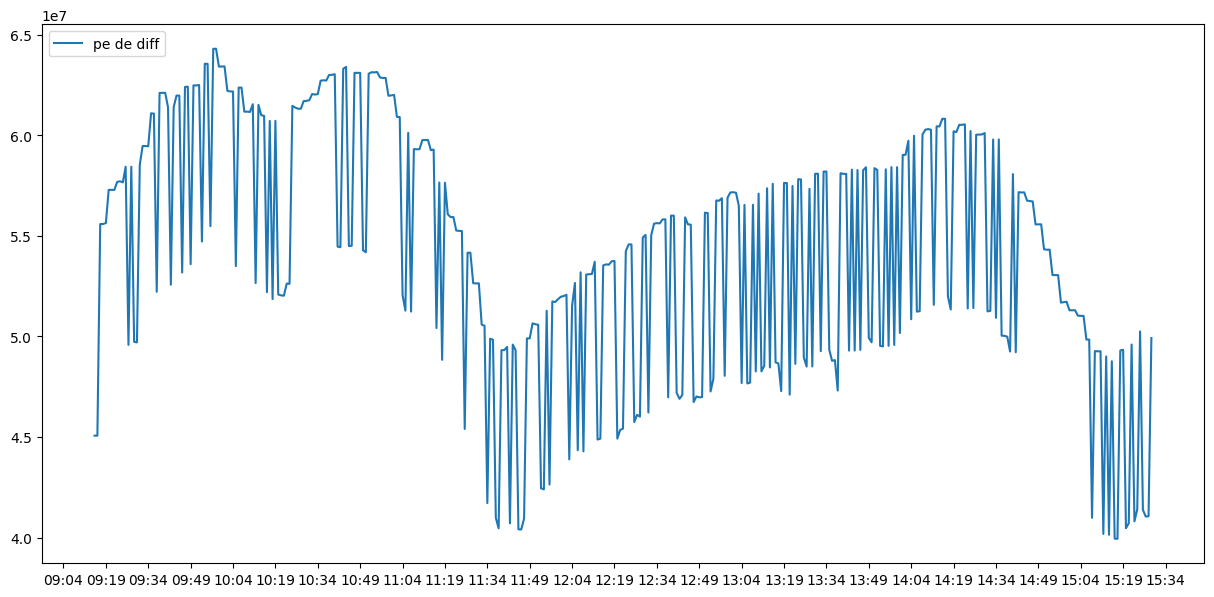

In [56]:
def getOI(data, instrument):
    df = pd.DataFrame(data)
    df['timestamp'] = df['timestamp'].apply(lambda ts: ts.replace(second=0))
    df = df.drop_duplicates(subset=['timestamp', 'instrument_name'], keep='last')
    df = df.groupby(['timestamp'])['oi'].sum().reset_index(name=instrument)
    return df

df = pd.DataFrame()
df['timestamp'] = getOI(niftyPeList, 'pe')['timestamp']
df['pe'] = getOI(niftyPeList, 'pe')['pe']
df['ce'] = getOI(niftyCeList, 'ce')['ce']
df['pe de diff'] = df['pe'] - df['ce']

def getMovingAverage(df, colName, window):
    df[colName] = df['pe de diff'].rolling(window).mean()
    return df

df = getMovingAverage(df, '3min ma', 3)
df = getMovingAverage(df, '5min ma', 5)
df = getMovingAverage(df, '15min ma', 15)

df.to_excel('nifty.xlsx', index=False)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df['timestamp'], df['pe de diff'], label='pe de diff')
# ax.plot(df['timestamp'], df['3min ma'], label='3min ma')
# ax.plot(df['timestamp'], df['5min ma'], label='5min ma')
# ax.plot(df['timestamp'], df['15min ma'], label='15min ma')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
plt.legend(loc='upper left')
plt.show()


# New Graph Analysis

In [66]:
niftyPeList = list(db['NIFTY200723_170723'].find({'type':'PE'}))
df = pd.DataFrame(niftyPeList)
df['data_collected'] = df['data_collected'].apply(lambda ts: ts.replace(second=0))
df = df.drop_duplicates(subset=['data_collected', 'instrument_name'], keep='last')
bf = df.groupby(['data_collected'])['oi'].sum().reset_index(name='pe')

niftyCeList = list(db['NIFTY200723_170723'].find({'type':'CE'}))
df = pd.DataFrame(niftyCeList)
df['data_collected'] = df['data_collected'].apply(lambda ts: ts.replace(second=0))
df = df.drop_duplicates(subset=['data_collected', 'instrument_name'], keep='last')
cf = df.groupby(['data_collected'])['oi'].sum().reset_index(name='ce')

# merge the two dataframes
df = pd.merge(bf, cf, on='data_collected')

# create a new column pe-ce
df['pe-ce'] = df['pe'] - df['ce']

df['data_collected'] = df['data_collected'].apply(lambda ts: ts + timedelta(hours=5, minutes=30))

bf = df
bf

,data_collected,pe,ce,pe-ce
0,2023-07-17 09:15:00,96313925,87768500,8545425
1,2023-07-17 09:16:00,96313925,87768500,8545425
2,2023-07-17 09:17:00,96313925,87768500,8545425
3,2023-07-17 09:18:00,100857625,90439950,10417675
4,2023-07-17 09:19:00,100857675,90441150,10416525
...,...,...,...,...
370,2023-07-17 15:25:00,130168725,83388300,46780425
371,2023-07-17 15:26:00,130170625,83387250,46783375
372,2023-07-17 15:27:00,130170625,83387400,46783225
373,2023-07-17 15:28:00,128819425,83073500,45745925


In [67]:
bf.to_excel('nifty_17_07_23.xlsx', index=False)
bf

,data_collected,pe,ce,pe-ce
0,2023-07-17 09:15:00,96313925,87768500,8545425
1,2023-07-17 09:16:00,96313925,87768500,8545425
2,2023-07-17 09:17:00,96313925,87768500,8545425
3,2023-07-17 09:18:00,100857625,90439950,10417675
4,2023-07-17 09:19:00,100857675,90441150,10416525
...,...,...,...,...
370,2023-07-17 15:25:00,130168725,83388300,46780425
371,2023-07-17 15:26:00,130170625,83387250,46783375
372,2023-07-17 15:27:00,130170625,83387400,46783225
373,2023-07-17 15:28:00,128819425,83073500,45745925


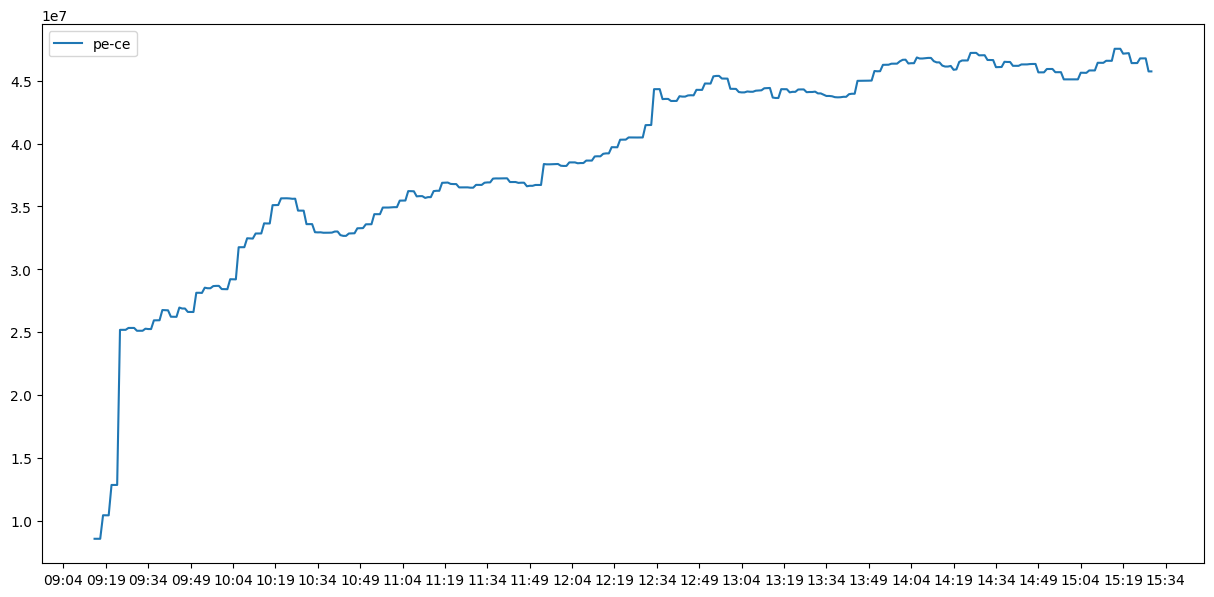

In [68]:
# plot the graph with x-axis as time and y-axis as pe-ce values
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(bf['data_collected'], bf['pe-ce'], label='pe-ce')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
plt.legend(loc='upper left')
plt.show()